# Opens fits files and displays info, works with csvs to produce location plots etc.

In [1]:
# Call the relevant python packages

%matplotlib notebook

import math
import numpy as np
import pandas as pd
import glob, os
import nway

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from astropy import units as u
from astropy.io import ascii, fits
from astropy.table import join, hstack, Table, Column, vstack
from astropy.coordinates import Angle, Latitude, Longitude, SkyCoord

# Set colour palette & plot layouts
import seaborn as sns     #; sns.set()
sns.set_context("paper")   # "paper", "notebook", "talk", "poster"

# Fits Files

In [2]:
# Open a fits file and display info
filein = 'single_match/36_1_3_matched.fits'
fits_im = fits.open(filein)
fits_im.info()

# Print data
data = fits_im[1].data
print(len(data))
print(data[0:2])

Filename: single_match/36_1_3_matched.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1  NWAYMATCH     1 BinTableHDU     47   12268R x 19C   [21A, D, D, D, D, 21A, D, D, D, D, E, E, I, E, E, E, E, E, I]   
12268
[('1', 10.60573757, 40.8624973 , 17.52850491, 0.0556, '-99', -99., -99., -99., -99., nan, 0., 1, 0., 1., 1., 0., 0., 1)
 ('3', 10.62889238, 40.81041431, 17.55350491, 0.0682, '-99', -99., -99., -99., -99., nan, 0., 1, 0., 1., 1., 0., 0., 1)]


In [3]:
# Print fits header fields
hdr = fits_im[1].header
hdr

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  138 / length of dimension 1                          
NAXIS2  =                12268 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   19 / number of table fields                         
TTYPE1  = 'S1_F1_ID'                                                            
TFORM1  = '21A     '                                                            
TTYPE2  = 'S1_F1_RA'                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'S1_F1_DEC'       

# Convert fits to text

In [7]:
text_file = open('single_match/36_1_3_text.txt','w')
for i in range(8,len(hdr)-1,2):
    name = str(hdr[i])+' '
    print(name)
    text_file.write(name)
    
for i in range(len(data)):
    line = '\n'+str(data[i])[1:len(str(data[i]))-1]+' '
    text_file.write(line)
    
text_file.close()

S1_F1_ID 
S1_F1_RA 
S1_F1_DEC 
S1_F1_MAG1_1 
S1_F1_ERR1_1 
S1_F3_ID 
S1_F3_RA 
S1_F3_DEC 
S1_F3_MAG1_3 
S1_F3_ERR1_3 
Separation_S1_F3_S1_F1 
Separation_max 
ncat 
dist_bayesfactor 
dist_post 
p_single 
p_any 
p_i 
match_flag 


# Match visualisation (ignores sky curvature)

0.24520263593797173 arcsec
5.555555555555556e-05 deg


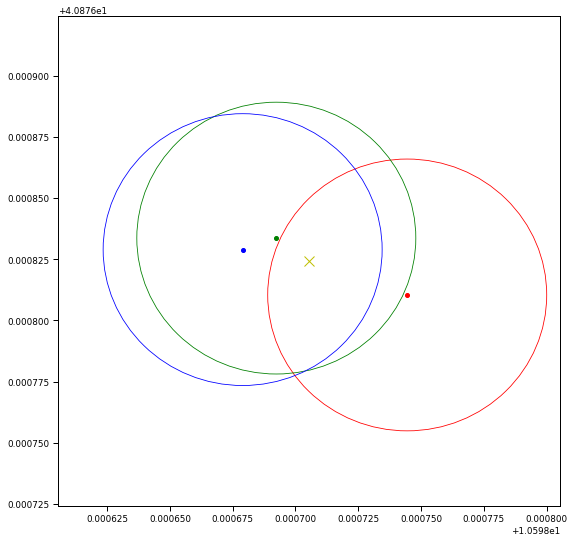

In [6]:
%matplotlib inline
plt.figure(figsize=(9,9))
x1,y1 = 10.5987445,40.87681039
x2,y2 = 10.59869237,40.87683363
x3,y3 = 10.59867896,40.87682893
sep13 = math.sqrt((x3-x1)**2 + (y3-y1)**2) * u.degree
sep13 = sep13.to(u.arcsec)
print(sep13)
plt.plot(x1,y1,'ro',ms=4)
plt.plot(x2,y2,'go',ms=4)
plt.plot(x3,y3,'bo',ms=4)
stretch = 0.0001
x_mean = (x1+x2+x3)/3
y_mean = (y1+y2+y3)/3
plt.plot(x_mean,y_mean,'yx',ms=10)
plt.xlim(x_mean-stretch,x_mean+stretch)
plt.ylim(y_mean-stretch,y_mean+stretch)

ax = plt.gca()
radius = 0.2*u.arcsec
radius = radius.to(u.deg)
print(radius)
circle1 = plt.Circle((x1,y1), radius.value, color='red', fill=False) #max allowed radius
circle2 = plt.Circle((x2,y2), radius.value, color='green', fill=False) #actual separation
circle3 = plt.Circle((x3,y3), radius.value, color='blue', fill=False) #actual separation

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)

# Catalogue Operations

In [10]:
# Define function to produce 3D graph
# NB: ONLY WORKS FOR CSV FILES!!
def graph(file,filtr,epoch,var):
    # Setting up figure
    plt.rc('font', family='sans-serif')
    #plt.rc("xtick", labelsize=8)
    #plt.rc("ytick", labelsize=8)
    plt.rc("axes", labelsize=10)
    plt.rc("legend", fontsize=11)
    plt.figure(figsize=(6,6))
    #ax = plt.gca()                        # Sets up active plot region
    ax = plt.axes(projection='3d')
    
    # Make the actual plot
    data = ascii.read(file, data_start=1)
    ax.plot3D(data['RA'], data['DEC'], data[var], '.', color='black', ms=0.5, label="M32 All")
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    ax.set_zlabel(var)
    #plt.xlabel('RA', size=18)
    #plt.ylabel('DEC', size=18)
    #plt.zlabel(var, size=18)
    #plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
    #plt.title(filtr+'-'+epoch,fontsize=18)
    
    # Plot a box
    #x1,y1=[maxRA.value,minRA.value],[minDec.value,minDec.value]
    #x2,y2=[minRA.value,minRA.value],[minDec.value,maxDec.value]
    #x3,y3=[minRA.value,maxRA.value],[maxDec.value,maxDec.value]
    #x4,y4=[maxRA.value,maxRA.value],[maxDec.value,minDec.value]
    #plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,color='black')
    
    #plt.savefig("blah.pdf", bbox_inches='tight')
    #plt.tight_layout()
    #plt.show()
    #plt.close()

<IPython.core.display.Javascript object>


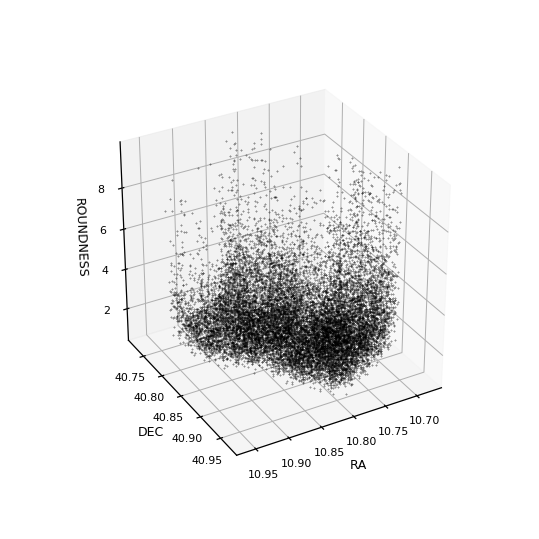

In [11]:
graph('MAG_S1_0.csv','36','background','ROUNDNESS')
#graph(csvfile,'36','background','SHARPNESS')
#graph(csvfile,'36','background','MAG1')
#graph(csvfile,'36','background','ERR1')

In [4]:
# Define function to produce location plot
def loc_plot(file,filtr,epoch):
    %matplotlib inline
    # Setting up figure
    plt.rc('font', family='sans-serif')
    plt.rc("xtick", labelsize=14)
    plt.rc("ytick", labelsize=14)
    plt.rc("axes", labelsize=14)
    plt.rc("legend", fontsize=11)
    plt.figure(figsize=(9,9))
    ax = plt.gca()                        # Sets up active plot region
    
    # Make the actual plot
    data = ascii.read(file, data_start=1)
    plt.plot(data['RA'], data['DEC'], '.', color='black', ms=0.2, label="M32 All")    
    plt.xlabel('Right Ascension (deg)', size=18)
    plt.ylabel('Declination (deg)', size=18)
    plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
    plt.title(filtr+'-'+epoch,fontsize=18)
    
    # Plot a box
    #x1,y1=[maxRA.value,minRA.value],[minDec.value,minDec.value]
    #x2,y2=[minRA.value,minRA.value],[minDec.value,maxDec.value]
    #x3,y3=[minRA.value,maxRA.value],[maxDec.value,maxDec.value]
    #x4,y4=[maxRA.value,maxRA.value],[maxDec.value,minDec.value]
    #plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,color='black')
    
    #plt.savefig("blah.pdf", bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    plt.close()

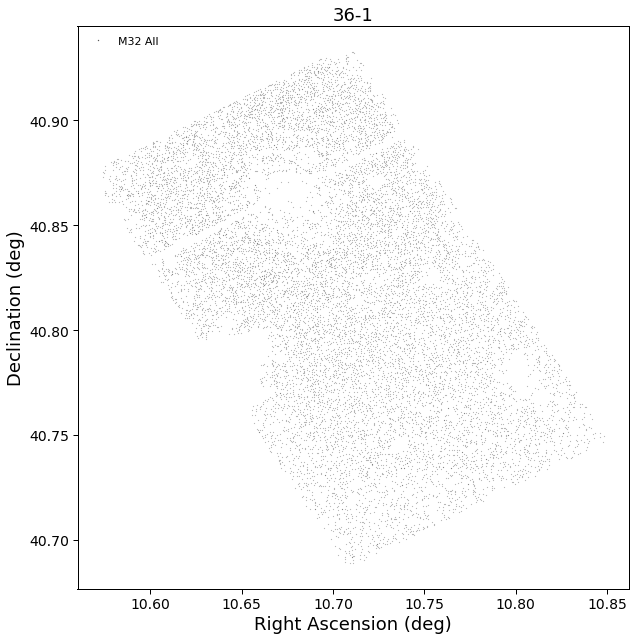

In [6]:
# Show location plot of background 36 field
loc_plot('MAG_S1_1.csv','36','1')

In [27]:
#print column names
data_36.colnames

['RA', 'DEC', 'ROUNDESS', 'SHARPNESS', 'MAG1', 'ERR1']

In [13]:
file = 'single_match/36_1_3_text.csv'
csv_data = ascii.read(file, header_start=0)
csv_data.colnames   # Get the column names
print("Number of rows:",len(csv_data))

# Cull all those matches with a match flag !=1    
good_match_idx = np.where(csv_data['match_flag']==1)
good_data = csv_data[good_match_idx]
print("Amount of good match data:",len(good_data))

# See how many remain compared to original combined [3.6]/[4.5]
match_1_pct = len(good_data)*100/len(csv_data)
print("Percentage of good match data: ",match_1_pct,"%")

# Set up columns for association number and mean coordinates
good_data['asn']=0
good_data['RA']=0.0
good_data['DEC']=0.0

for i in range(len(good_data)):
    associations = 1
    RA = good_data['S1_F1_RA'][i]
    DEC = good_data['S1_F1_DEC'][i]
    
    # -99 means no match, so ignore these coordinates
    if good_data['S1_F3_RA'][i]!=-99:
        RA = RA + good_data['S1_F3_RA'][i]
        DEC = DEC + good_data['S1_F3_DEC'][i]
        associations = associations + 1
    #if good_data['S2_F4_RA'][i]!=-99:
    #    RA = RA + good_data['S2_F4_RA'][i]
    #    DEC = DEC + good_data['S2_F4_DEC'][i]
    #    associations = associations + 1
        
    good_data['asn'][i]=associations
    good_data['RA'][i]=RA/associations
    good_data['DEC'][i]=DEC/associations
    
#asn_3_idx = np.where(good_data['45_asn']==3)
#print("3 out of 3 associations:",len(asn_3_idx[0]))
asn_2_idx = np.where(good_data['asn']==2)
print("2 out of 2 associations",len(asn_2_idx[0]))
#idx_asn = np.where(good_data['asn']!=1)
# Cull those with no counterparts (no variability)
#print("This number should be the sum of the two above:",len(idx_asn[0]))
#good_asn_data = good_data[idx_asn]
# See how many remain compared to original combined [3.6]/[4.5]
#good_asn_pct = 100*len(good_asn_data)/len(csv_data)
#print("Amount of good match data with counterpart(s): ",good_asn_pct,"%")

# Rename 1st ID as ID
good_data.rename_column('S1_F1_ID', 'ID')

# Remove first and last characters of ID number ('')
col_change_list = ['ID','S1_F3_ID']
for i in range(len(good_data)):
    for j in range(len(col_change_list)):
        good_data[col_change_list[j]][i]=int(str(good_data[col_change_list[j]][i])[1:len(str(good_data[col_change_list[j]][i]))-1])

# Rename (ID, RA, Dec)1 as (ID, RA, Dec)
#good_data.rename_column('S2_F1_ID', 'ID')
#good_data.rename_column('S2_F1_RA', 'RA')
#good_data.rename_column('S2_F1_DEC', 'DEC')

#good_asn_data.write('all_good_45_mean_csv.csv', overwrite=True)
good_data.write('single_match/36_1_3_good_mean_fits.fits', overwrite=True)

# Display a small portion of the data to check formatting
good_data[0:2].show_in_notebook()

Number of rows: 7353
Amount of good match data: 6077
Percentage of good match data:  82.64653882768938 %
2 out of 2 associations 1271


idx,ID,S1_F1_RA,S1_F1_DEC,S1_F1_MAG1_1,S1_F1_ERR1_1,S1_F3_ID,S1_F3_RA,S1_F3_DEC,S1_F3_MAG1_3,S1_F3_ERR1_3,Separation_S1_F3_S1_F1,Separation_max,ncat,dist_bayesfactor,dist_post,p_single,p_any,p_i,match_flag,asn,RA,DEC
0,1,10.60573757,40.8624973,17.52850491,0.0556,-99,-99.0,-99.0,-99.0,-99.0,nan,0.0,1,0.0,1.0,1.0,0.0,0.0,1,1,10.60573757,40.8624973
1,3,10.62889238,40.81041431,17.55350491,0.0682,-99,-99.0,-99.0,-99.0,-99.0,nan,0.0,1,0.0,1.0,1.0,0.0,0.0,1,1,10.62889238,40.81041431


<IPython.core.display.Javascript object>


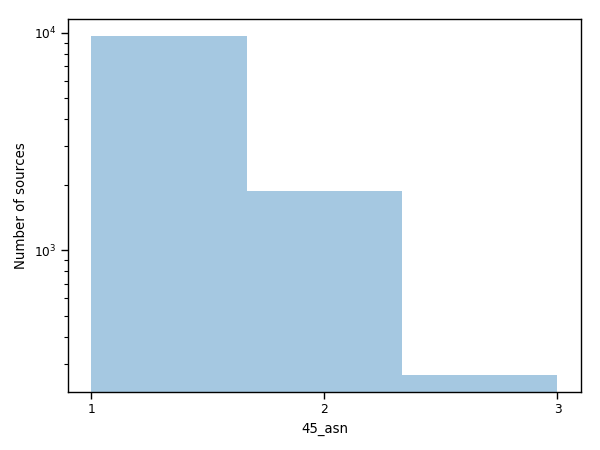

In [15]:
ig = plt.figure(figsize=(6,4.5))
ax = sns.distplot(good_data['45_asn'] ,kde=False, bins=3)
#ax = sns.countplot(pr_data[param_best_name], color='steelblue')
ax.set_yscale('log')
ax.set_ylabel('Number of sources')
plt.tight_layout()
ax.set_xticks([1,2,3])
#save_name = str('hist_'+param_best_name+'.pdf')
#plt.savefig(save_name, bbox_inches='tight')





# Can employ visualisation technique above to check mean coordinate

# Test to see if mean coordinates are working

In [ ]:
good_asn_data[0:6].show_in_notebook()

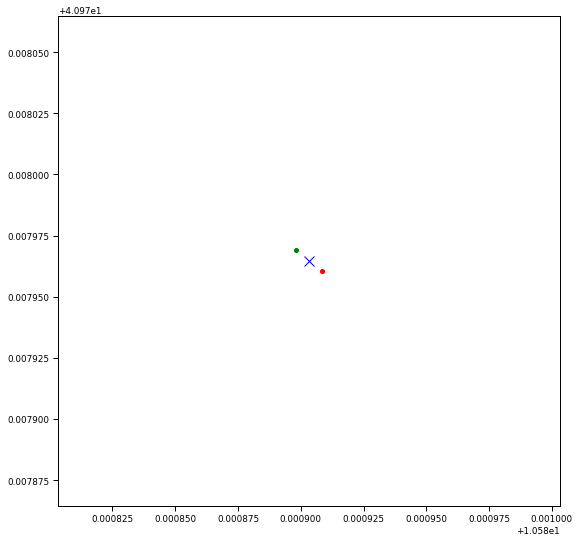

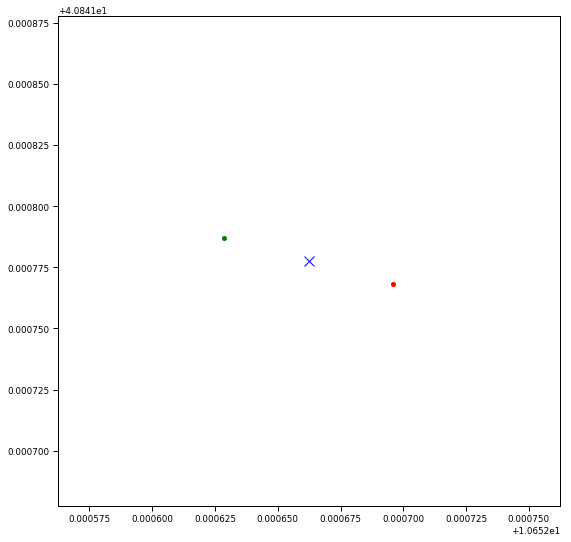

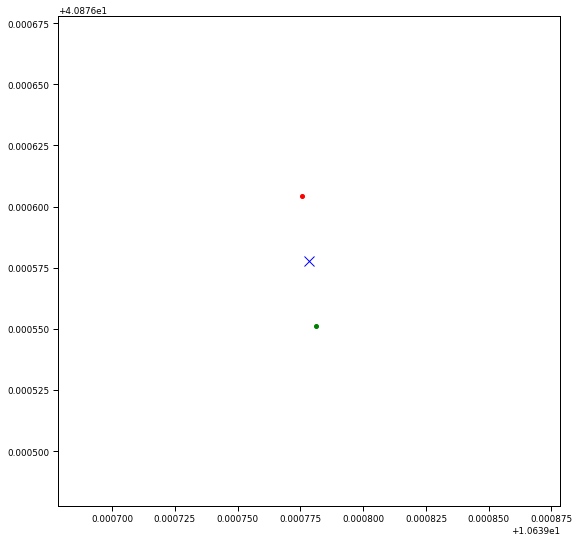

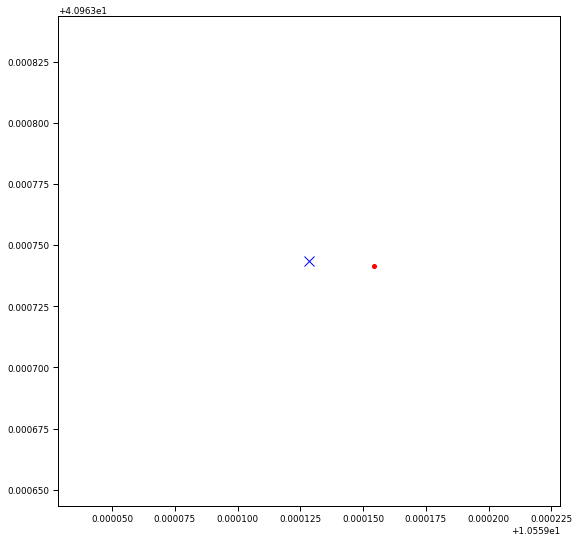

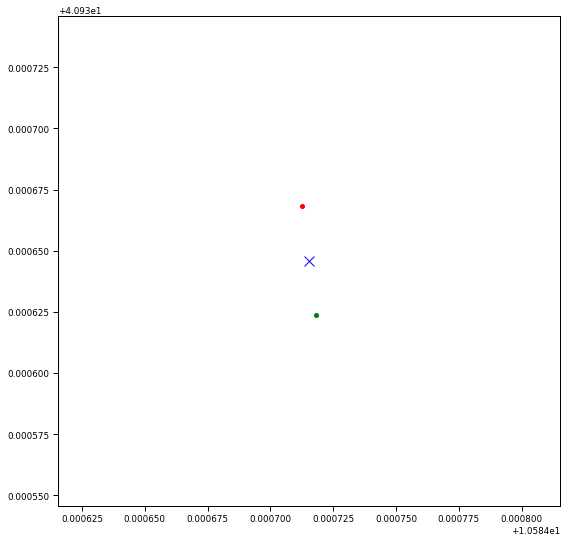

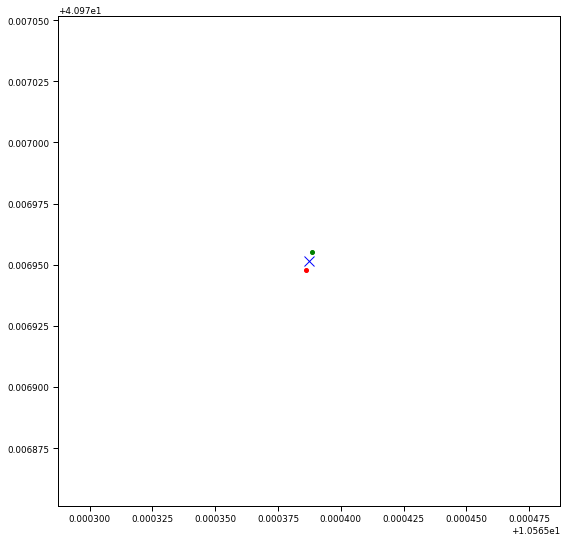

In [22]:
%matplotlib inline

# NB: This function assumes the 3rd coordinate is -99 (not used)
for i in range(6):
    plt.figure(figsize=(9,9))
    x1,y1 = good_asn_data['S2_F1_RA'][i],good_asn_data['S2_F1_DEC'][i]
    x2,y2 = good_asn_data['S2_F3_RA'][i],good_asn_data['S2_F3_DEC'][i]
    x3,y3 = good_asn_data['RA'][i],good_asn_data['DEC'][i]

    plt.plot(x1,y1,'ro',ms=4)
    plt.plot(x2,y2,'go',ms=4)
    plt.plot(x3,y3,'bx',ms=10)
    stretch = 0.0001
    plt.xlim(x3-stretch,x3+stretch)
    plt.ylim(y3-stretch,y3+stretch)